In [ ]:
'''Ce script permet de mesurer la correlation entre le ratio de type et le ratio de longeur des mots,
et le P-value,
éliminer les données abérantes avec z-score > 3,
augementer les données avec la façon retraduction en utlisant MarianMT,
et puis évaluer le corpus avec Rouge'''

In [50]:
import json
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, zscore
import torch
from transformers import (
    RobertaTokenizer,
    RobertaForCausalLM,
    MarianMTModel,
    MarianTokenizer,
)
from rouge_score import rouge_scorer, scoring

In [7]:
# chargement des modèles
nlp_en = spacy.load("en_core_web_sm")
nlp_fr = spacy.load("fr_core_news_sm")

# chargement des modèles de traduction
with open("../data/clean/corpus_traité.json", "r", encoding="utf-8") as file:
    corpus = [json.loads(line) for line in file]

# création d'un dataframe
df = pd.DataFrame(corpus)

In [8]:
def calculate_lexical_diversity_and_length(df, lang, nlp):
    # fonction pour calculer la similarité entre deux textes
    lexical_diversity = []
    sentence_length = []

    for text in df[lang]:
        doc = nlp(text)
        tokens = [token.text for token in doc if token.is_alpha]
        unique_tokens = set(tokens)

        # le ratio de type-token
        ttr = len(unique_tokens) / len(tokens) if len(tokens) > 0 else 0
        lexical_diversity.append(ttr)

        # le nombre de mots par phrase
        sentence_length.append(len(tokens))

    return lexical_diversity, sentence_length

In [9]:
en_lexical_diversity, en_sentence_length = calculate_lexical_diversity_and_length(
    df, "en", nlp_en
)
fr_lexical_diversity, fr_sentence_length = calculate_lexical_diversity_and_length(
    df, "fr", nlp_fr
)

# calcul de la corrélation de Pearson
en_corr, en_p_value = pearsonr(en_lexical_diversity, en_sentence_length)
fr_corr, fr_p_value = pearsonr(fr_lexical_diversity, fr_sentence_length)

print(f"English - Pearson correlation: {en_corr}, p-value: {en_p_value}")
print(f"French - Pearson correlation: {fr_corr}, p-value: {fr_p_value}")

English - Pearson correlation: -0.6494533375283146, p-value: 2.9748981695036403e-289
French - Pearson correlation: -0.5663844701609291, p-value: 7.12968168203073e-205


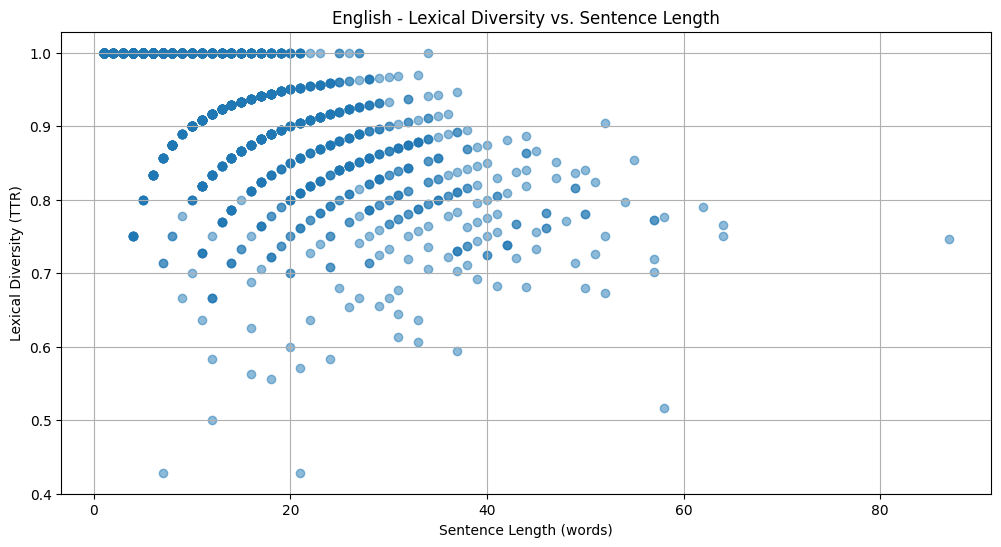

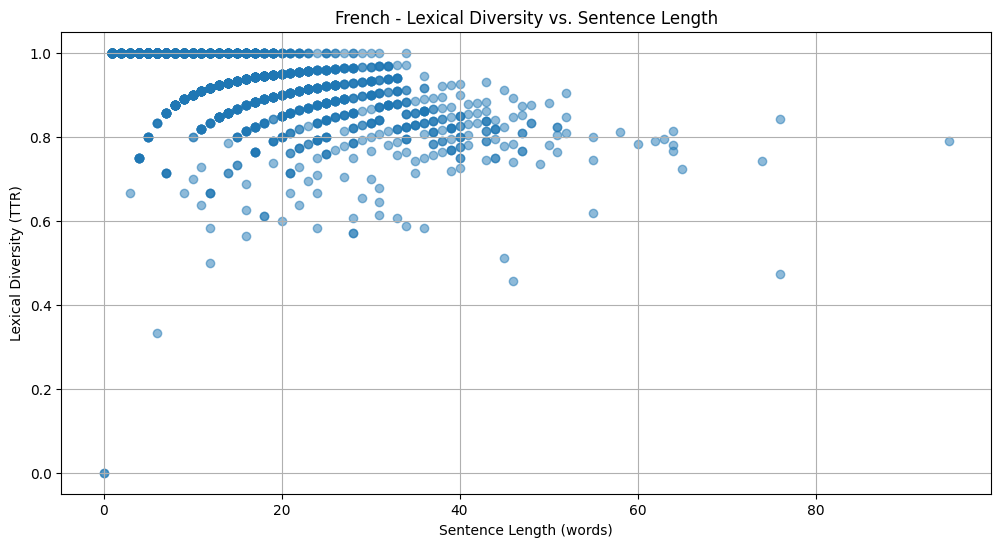

In [10]:
def plot_lexical_diversity_length(lexical_diversity, sentence_length, language):
    # visualisation de la corrélation entre la diversité lexicale et la longueur des phrases
    plt.figure(figsize=(12, 6))
    plt.scatter(sentence_length, lexical_diversity, alpha=0.5)
    plt.xlabel("Sentence Length (words)")
    plt.ylabel("Lexical Diversity (TTR)")
    plt.title(f"{language} - Lexical Diversity vs. Sentence Length")
    plt.grid(True)
    plt.show()


plot_lexical_diversity_length(en_lexical_diversity, en_sentence_length, "English")
plot_lexical_diversity_length(fr_lexical_diversity, fr_sentence_length, "French")

In [11]:
# ajout des colonnes au dataframe
df["en_lexical_diversity"] = en_lexical_diversity
df["en_sentence_length"] = en_sentence_length
df["fr_lexical_diversity"] = fr_lexical_diversity
df["fr_sentence_length"] = fr_sentence_length

In [12]:
# calcul des z-scores
df["en_lexical_diversity_z"] = zscore(df["en_lexical_diversity"])
df["en_sentence_length_z"] = zscore(df["en_sentence_length"])
df["fr_lexical_diversity_z"] = zscore(df["fr_lexical_diversity"])
df["fr_sentence_length_z"] = zscore(df["fr_sentence_length"])

In [13]:
# mettre en évidence les valeurs aberrantes
threshold = 3

# détection des valeurs aberrantes
df["en_outlier"] = (abs(df["en_lexical_diversity_z"]) > threshold) | (
    abs(df["en_sentence_length_z"]) > threshold
)
df["fr_outlier"] = (abs(df["fr_lexical_diversity_z"]) > threshold) | (
    abs(df["fr_sentence_length_z"]) > threshold
)

# filtrage des valeurs aberrantes
df_filtered = df[~df["en_outlier"] & ~df["fr_outlier"]].copy()

print(f"Original data size: {len(df)}")
print(f"Filtered data size: {len(df_filtered)}")

Original data size: 2414
Filtered data size: 2286


In [14]:
# chargement des modèles RoBERTa
# tokenizer_en = RobertaTokenizer.from_pretrained('roberta-base')
# model_en = RobertaForCausalLM.from_pretrained('roberta-base', is_decoder=True)

# tokenizer_fr = RobertaTokenizer.from_pretrained('roberta-base')
# model_fr = RobertaForCausalLM.from_pretrained('roberta-base', is_decoder=True)

In [15]:
# def augment_corpus(sentences, tokenizer, model, num_return_sequences=3, max_new_tokens=50, temperature=1.0, top_k=50, top_p=0.9):
# fonction pour augmenter le corpus
#    augmented_sentences = []
#     for sentence in sentences:
#         inputs = tokenizer(sentence, return_tensors="pt", truncation=True)
#         outputs = model.generate(
#             inputs['input_ids'],
#             max_new_tokens=max_new_tokens,
#             num_return_sequences=num_return_sequences,
#             do_sample=True,
#             temperature=temperature,
#             top_k=top_k,
#             top_p=top_p
#         )
#         for output in outputs:
#             augmented_sentence = tokenizer.decode(output, skip_special_tokens=True)
#             augmented_sentences.append(augmented_sentence)
#     return augmented_sentences

In [16]:
# # récupération des phrases en anglais et en français
# en_sentences = df_filtered['en'].tolist()
# fr_sentences = df_filtered['fr'].tolist()

# traitement des données pour l'augmentation
# batch_size = 10
# all_augmented_en_sentences = []
# all_augmented_fr_sentences = []

In [17]:
# # augmentation des phrases en anglais
# for i in range(0, len(en_sentences), batch_size):
#     batch_en_sentences = en_sentences[i:i + batch_size]
#     augmented_en_sentences = augment_corpus(batch_en_sentences, tokenizer_en, model_en)
#     all_augmented_en_sentences.extend(augmented_en_sentences)

In [18]:
# # augmentation des phrases en français
# for i in range(0, len(fr_sentences), batch_size):
#     batch_fr_sentences = fr_sentences[i:i + batch_size]
#     augmented_fr_sentences = augment_corpus(batch_fr_sentences, tokenizer_fr, model_fr)
#     all_augmented_fr_sentences.extend(augmented_fr_sentences)

In [19]:
# # affichage des phrases augmentées
# print("Enhanced English Sentences:")
# for i, augmented_sentence in enumerate(all_augmented_en_sentences[:10], 1):
#     print(f"Augmented Sentence {i}: {augmented_sentence}")

# print("\nEnhanced French Sentences:")
# for i, augmented_sentence in enumerate(all_augmented_fr_sentences[:10], 1):
#     print(f"Augmented Sentence {i}: {augmented_sentence}")

In [56]:
# chargement des modèles de traduction et des tokenizers
model_name_en_to_fr = "Helsinki-NLP/opus-mt-en-fr"
model_name_fr_to_en = "Helsinki-NLP/opus-mt-fr-en"

tokenizer_en_to_fr = MarianTokenizer.from_pretrained(model_name_en_to_fr)
model_en_to_fr = MarianMTModel.from_pretrained(model_name_en_to_fr)

tokenizer_fr_to_en = MarianTokenizer.from_pretrained(model_name_fr_to_en)
model_fr_to_en = MarianMTModel.from_pretrained(model_name_fr_to_en)


def back_translate(
    sentences,
    tokenizer_src_to_tgt,
    model_src_to_tgt,
    tokenizer_tgt_to_src,
    model_tgt_to_src,
):
    # fonction pour retourner les phrases traduites
    translated_sentences = []
    back_translated_sentences = []

    # traduction de la source vers la cible
    for sentence in sentences:
        inputs = tokenizer_src_to_tgt(sentence, return_tensors="pt", truncation=True)
        outputs = model_src_to_tgt.generate(**inputs)
        translated_sentence = tokenizer_src_to_tgt.decode(
            outputs[0], skip_special_tokens=True
        )
        translated_sentences.append(translated_sentence)

    # traduction de la cible vers la source
    for sentence in translated_sentences:
        inputs = tokenizer_tgt_to_src(sentence, return_tensors="pt", truncation=True)
        outputs = model_tgt_to_src.generate(**inputs)
        back_translated_sentence = tokenizer_tgt_to_src.decode(
            outputs[0], skip_special_tokens=True
        )
        back_translated_sentences.append(back_translated_sentence)

    return back_translated_sentences

In [76]:
"""j'utilise les 100 phrases pour tester car le corpus est trop grand pour mon ordinateur, 
cela prendrait 1 h et n'a pas encore terminé 
alors que je sais que l'évaluation sera mauvaises 
vu que le corpus n'est pas bien aligné"""

en_sentences = df_filtered["en"].tolist()[:100]
fr_sentences = df_filtered["fr"].tolist()[:100]

In [77]:
# augmentation des phrases en anglais
augmented_en_sentences = back_translate(
    en_sentences, tokenizer_en_to_fr, model_en_to_fr, tokenizer_fr_to_en, model_fr_to_en
)

In [84]:
# augmentation des phrases en français
augmented_fr_sentences = back_translate(
    fr_sentences, tokenizer_fr_to_en, model_fr_to_en, tokenizer_en_to_fr, model_en_to_fr
)

In [85]:
# affichage des phrases augmentées
print("Back-translated English Sentences:")
for i, augmented_sentence in enumerate(augmented_en_sentences[:10], 1):
    print(f"Augmented Sentence {i}: {augmented_sentence}")

print("\nBack-translated French Sentences:")
for i, augmented_sentence in enumerate(augmented_fr_sentences[:10], 1):
    print(f"Augmented Sentence {i}: {augmented_sentence}")

Back-translated English Sentences:
Augmented Sentence 1: Hello, old friend.
Augmented Sentence 2: People feel overwhelmed.
Augmented Sentence 3: (Laughter)
Augmented Sentence 4: These people reach thousands, if not millions, of readers, and it's incredibly important.
Augmented Sentence 5: That's what happened to me.
Augmented Sentence 6: I only prepared 15."
Augmented Sentence 7: (Laughter)
Augmented Sentence 8: as in the TED sense?"
Augmented Sentence 9: And finally, you know, become freelance.
Augmented Sentence 10: (Laughter)

Back-translated French Sentences:
Augmented Sentence 1: Bonjour répondeur, vieil ami.
Augmented Sentence 2: Que c'est trop de technologie, trop rapide.
Augmented Sentence 3: (Rires) Je connais les ficelles maintenant, je sais ce que c'est.
Augmented Sentence 4: J'ai aussi un ami, qui a un blog numérique -- sur un PDR, un enregistreur personnel.
Augmented Sentence 5: Je pensais gagner un prix, parce que je n'avais jamais gagné un prix.
Augmented Sentence 6: (Ap

In [86]:
# combinaison des phrases augmentées et des phrases originales en anglais
enhanced_and_original_en = list(zip(augmented_en_sentences, en_sentences))

# combinaison des phrases augmentées et des phrases originales en français
enhanced_and_original_fr = list(zip(augmented_fr_sentences, fr_sentences))

In [87]:
# sauvegarde des données augmentées dans un fichier JSON
data_to_save = []
for (aug_en, orig_en), (aug_fr, orig_fr) in zip(
    enhanced_and_original_en, enhanced_and_original_fr
):
    data_to_save.append(
        {
            "augmented_en": aug_en,
            "original_en": orig_en,
            "augmented_fr": aug_fr,
            "original_fr": orig_fr,
        }
    )

output_file = "../data/clean/augmented_corpus.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(data_to_save, f, ensure_ascii=False, indent=4)

print(f"Data saved to {output_file}")

Data saved to ../data/clean/augmented_corpus.json


In [88]:
# création d'un objet scorer pour calculer les scores ROUGE
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
aggregator_en_fr = scoring.BootstrapAggregator()

# calcul des scores ROUGE pour les nouvelles corpus
enhanced_en_fr_pairs = list(zip(augmented_en_sentences, augmented_fr_sentences))
for augmented_en, augmented_fr in enhanced_en_fr_pairs:
    scores = scorer.score(augmented_en, augmented_fr)
    aggregator_en_fr.add_scores(scores)

result_en_fr = aggregator_en_fr.aggregate()

# affichage des scores ROUGE
data = {
    "Metric": [
        "ROUGE-1 Precision",
        "ROUGE-1 Recall",
        "ROUGE-1 F1",
        "ROUGE-2 Precision",
        "ROUGE-2 Recall",
        "ROUGE-2 F1",
        "ROUGE-L Precision",
        "ROUGE-L Recall",
        "ROUGE-L F1",
    ],
    "English to French": [
        result_en_fr["rouge1"].mid.precision,
        result_en_fr["rouge1"].mid.recall,
        result_en_fr["rouge1"].mid.fmeasure,
        result_en_fr["rouge2"].mid.precision,
        result_en_fr["rouge2"].mid.recall,
        result_en_fr["rouge2"].mid.fmeasure,
        result_en_fr["rougeL"].mid.precision,
        result_en_fr["rougeL"].mid.recall,
        result_en_fr["rougeL"].mid.fmeasure,
    ],
}

df_rouge = pd.DataFrame(data)

print(df_rouge)

              Metric  English to French
0  ROUGE-1 Precision           0.005547
1     ROUGE-1 Recall           0.009032
2         ROUGE-1 F1           0.006330
3  ROUGE-2 Precision           0.000000
4     ROUGE-2 Recall           0.000000
5         ROUGE-2 F1           0.000000
6  ROUGE-L Precision           0.005237
7     ROUGE-L Recall           0.008245
8         ROUGE-L F1           0.005883
